In [1]:
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.animation as animation
import numpy as np

In [2]:
blue = (0, 0, 1, 1)
green = (0, 1, 0, 1)
red = (1, 0, 0, 1)
black = (0,0,0,1)
grey = (0.3, .3, .3, 1)
g = 9.81 #m/s^2

def startFig():
    plt.close('all')
    fig = plt.figure(figsize=[10,10])
    #ax = fig.add_subplot(111, projection='3d')
    ax = Axes3D(fig)
    return ax

def arrow( ax, (x,y,z), (u,v,w), label, color, middle=False):  
    animate = ax.quiver(x,y,z, u,v,w, arrow_length_ratio=.05,\
                  colors=[color], linewidths=[2])
    if middle:
        ex,ey,ez = x+0.5*u, y+0.5*v, z+0.5*w
        offset=True
    else:
        ex,ey,ez = x+u, y+v, z+w
        offset=False
    label =drawLabel(ax, (ex,ey,ez), label, offset)
    
    return animate#, label

def drawLabel(ax, (x,y,z),label, offset=False):
    if offset:
        z += 0.25
    return ax.text(x,y,z, label, size=20)

    
def set_bounds(ax,X):
    x2,y2,z2 = np.max(X, axis=0) + 1
    x1,y1,z1 = np.min(X, axis=0) - 1

    ax.set_xlim3d(x1, x2)
    ax.set_ylim3d(y1, y2)
    ax.set_zlim3d(z1, z2)
    
        
def plotAll(A, B, rO, rQ, rPQ, rP, ax=None, labels=True):
    if ax is None:
        ax = startFig()
    
    bounds = [rO]
    
    E1, E2, E3 = A    
    # plot frame A
        
    arrow(ax, rO, E1, 'E1', black)
    arrow(ax, rO, E2, 'E2', black)
    arrow(ax, rO, E3, 'E3', black)
    if labels:drawLabel(ax, rO, 'O')
    
    if rP is not None:
        #plot point P observed in A
        arrow(ax, rO, rP, 'rP', green, middle=True)
        if labels:drawLabel(ax, rP, 'P')
        bounds.append(rP)
    
    
    #plot frame B
    if B is not None:
        #plot frame B
        e1, e2, e3 = B 
        if labels:
            arrow(ax, rQ, e1, 'e1', grey)
            arrow(ax, rQ, e2, 'e2', grey)
            arrow(ax, rQ, e3, 'e3', grey)          
        else:
            arrow(ax, rQ, e1, '', grey)
            arrow(ax, rQ, e2, '', grey)
            arrow(ax, rQ, e3, '', grey)
        
        # Plot point Q observed in A
        arrow(ax, rO, rQ ,'rQ', blue, middle=True)
        if labels:drawLabel(ax, rQ, 'Q')

        #plot point P observed in B
        arrow(ax, rQ, rPQ, 'rPQ', blue, middle=True)
        bounds = [rO, rPQ+rQ, rP, rQ]

        
    x2,y2,z2 = np.max(bounds, axis=0) + 1
    x1,y1,z1 = np.min(bounds, axis=0) - 1

    ax.set_xlim3d(x1, x2)
    ax.set_ylim3d(y1, y2)
    ax.set_zlim3d(z1,z2)

    plt.show()
    
def plotAbsMotion(A, rO, rP, ax = None):
    plotAll(A, None, rO, None, None, rP, ax)
    

In [3]:
def init_animation(ax, color):
    # set up lines and points
    lines = ax.plot([], [], [], '-', c=color)   
    pts = ax.plot([], [], [], 'o', c=color)
    trajs = ax.plot([], [], [], '--', c=color)
    #label =  ax.text(0, 0, 0, label, size=20)
    
    def init():
        for items in (lines, pts, trajs):
            for item in items:
                item.set_data([] , [])
                item.set_3d_properties([])    
        return lines + pts
    
    anims =(lines, pts, trajs)

    return anims, init

def setupAnimation(name_traj_color_list):
    # create plot with fixed frame A located at (0,0,0)
    A = np.eye(3) 
    rO = np.array((0,0,0))
    ax = startFig()
    fig = plt.gcf()
    plotAbsMotion(A, rO, None, ax)
    
    X_ts = []
    inits = []
    label_names = []
    anim_funcs = []
    
    for (name, traj, color) in name_traj_color_list:
        anims,  init = init_animation(ax, color)
        label_names.append(name)
        X_ts.append(traj)
        inits.append(init)
        anim_funcs.append(anims)
        
    set_bounds(ax,np.vstack(X_ts))
    
    def init_funcs():
        for init in inits:
            res = init()
        return res
    return ax, fig, X_ts, init_funcs, label_names, anim_funcs 


def runAnimation(ntc):
    
    ax, fig, X_ts, init_funcs, label_names, anim_funcs = setupAnimation(ntc)

    def animate(i):
        labels = []

        # loop
        for j in range(len(label_names)):

            x_t = X_ts[j]
            anims = anim_funcs[j]
            x, y, z = x_t[i]
            lines, pts, trajs = anims

            for line, pt, traj in zip(lines, pts, trajs):
                line.set_data([0,x], [0,y])
                line.set_3d_properties([0,z])
                pt.set_data(x, y)
                pt.set_3d_properties(z)
                traj.set_data(x_t[0:i,0], x_t[0:i,1])
                traj.set_3d_properties(x_t[0:i,2])
                labels.append(ax.text(x, y, z, label_names[j], size=20))

        fig.canvas.draw()
        for label in labels:
            label.set_text("")
        return lines + pts
    frames = len(X_ts[0])

    
    args = {
            'func':animate,
            'init_func':init_funcs,
            'frames':frames,
            'interval':30, 
            'blit':True
           }

    return fig, args



# Absolute Motion

During the first week we discussed reference frames and coordinate systems to represent the motion of particles.  This was the “absolute motion” that was always measured relative to a fixed reference frame.

Let's define the fixed reference frame  to be A

The particle moves in 3D.  The point the particle is located is denoted P.

Example 1: We observe a statue located at position P.


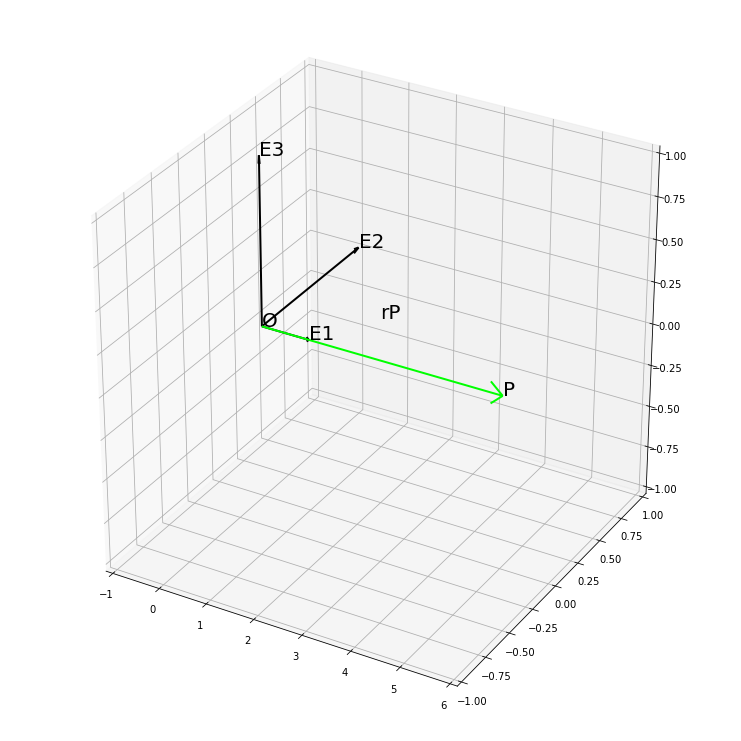

In [4]:
# Fixed Frame A
A = np.eye(3) # identity matrix E1=(1,0,0), E2=(0,1,0), E3=(0,0,1)
rO = np.array((0,0,0))
rP = np.array( (5, 0, 0))
plotAbsMotion(A, rO, rP)


Example 2: a projectile is launched into the air from the ground with an initial velocity v0 in the x,y, and z directions.  Assuming only gravity is acting on the projectile, what is it's equation of motion?  What about when the velocity is 0.5v0?


$^Ar_P(t) = v_0t\hat{E}_1 + v_0t\hat{E}_2 + (v_0t - \frac{1}{2}gt^2) \hat{E}_3$

In [5]:
# define path of trajectory for particle P observed in fixed frame A

def projectile(v0,t):
    x = v0*t
    y = v0*t
    z = v0*t - 0.5*g*t**2
    return [x,y,z]

T = np.linspace(0, 1, 100)
v0 = 5
x_t1 = np.array([projectile(v0,t) for t in T])
x_t2 = np.array([projectile(v0/2., t) for t in T])

ntc = [('rP1', x_t1, blue), 
       ('rP2', x_t2, green)]

# run animation
%matplotlib 
fig, args = runAnimation(ntc)
anim = animation.FuncAnimation(fig, **args)
plt.show()

Using matplotlib backend: Qt5Agg


# Relative Motion 

During the first week we discussed reference frames and coordinate systems to represent the motion of particles.  This was the “absolute motion” that was always measured relative to a fixed reference frame.

This week we are going to discuss relative motion.  In this case observations are made in a moving reference frame.  

Example case: I am in car driving in a straight line at 60 mph on the highway.  A car passes me going 20 mph faster than I am. How fast is the car going?


For this discussion, we will assume there is a fixed reference frame A and a moving reference frame B.   

* The fixed frame A’s coordinate system is represented by the basis {E1,E2,E3}
* The moving frame B’s coordinate system is represented by the basis {e1,e2,e3}
* O is the position of A’s origin
* Q is the position of B’s origin
* P  is a moving point observed



In [7]:
%matplotlib tk 
import time

# Fixed Frame A
A = np.eye(3) # identity matrix E1=(1,0,0), E2=(0,1,0), E3=(0,0,1)
rO = np.array((0,0,0))

# Moving Frame B
B = np.eye(3) # identity matrix
rQ = np.array([5., 5., 5.])

# moving point P observed in B
rPQ = np.array((0.,0.,0.))

# point P observed in A?
rP = rQ  + rPQ


# Position of rQ

vQ= np.array([1., 0., 0.])
vPQ = np.array([3.,0.0,0.])


dt = 4

plotAll(A, B, rO, rQ, rPQ, rP)
ax =plt.gca()
fig = plt.gcf()
plt.show(0)

for i in range(10):
    rQ += vQ*dt
    rPQ += vPQ*dt
    rP = rQ + rPQ
    plotAll(A, B, rO, rQ, rPQ, rP, ax, labels=False)
    time.sleep(dt*.5)
    fig.canvas.draw()
plotAll(A, B, rO, rQ, rPQ, rP)


plt.show()


